## Step-by-step explanation on the catalytic PFHX preliminary design tool

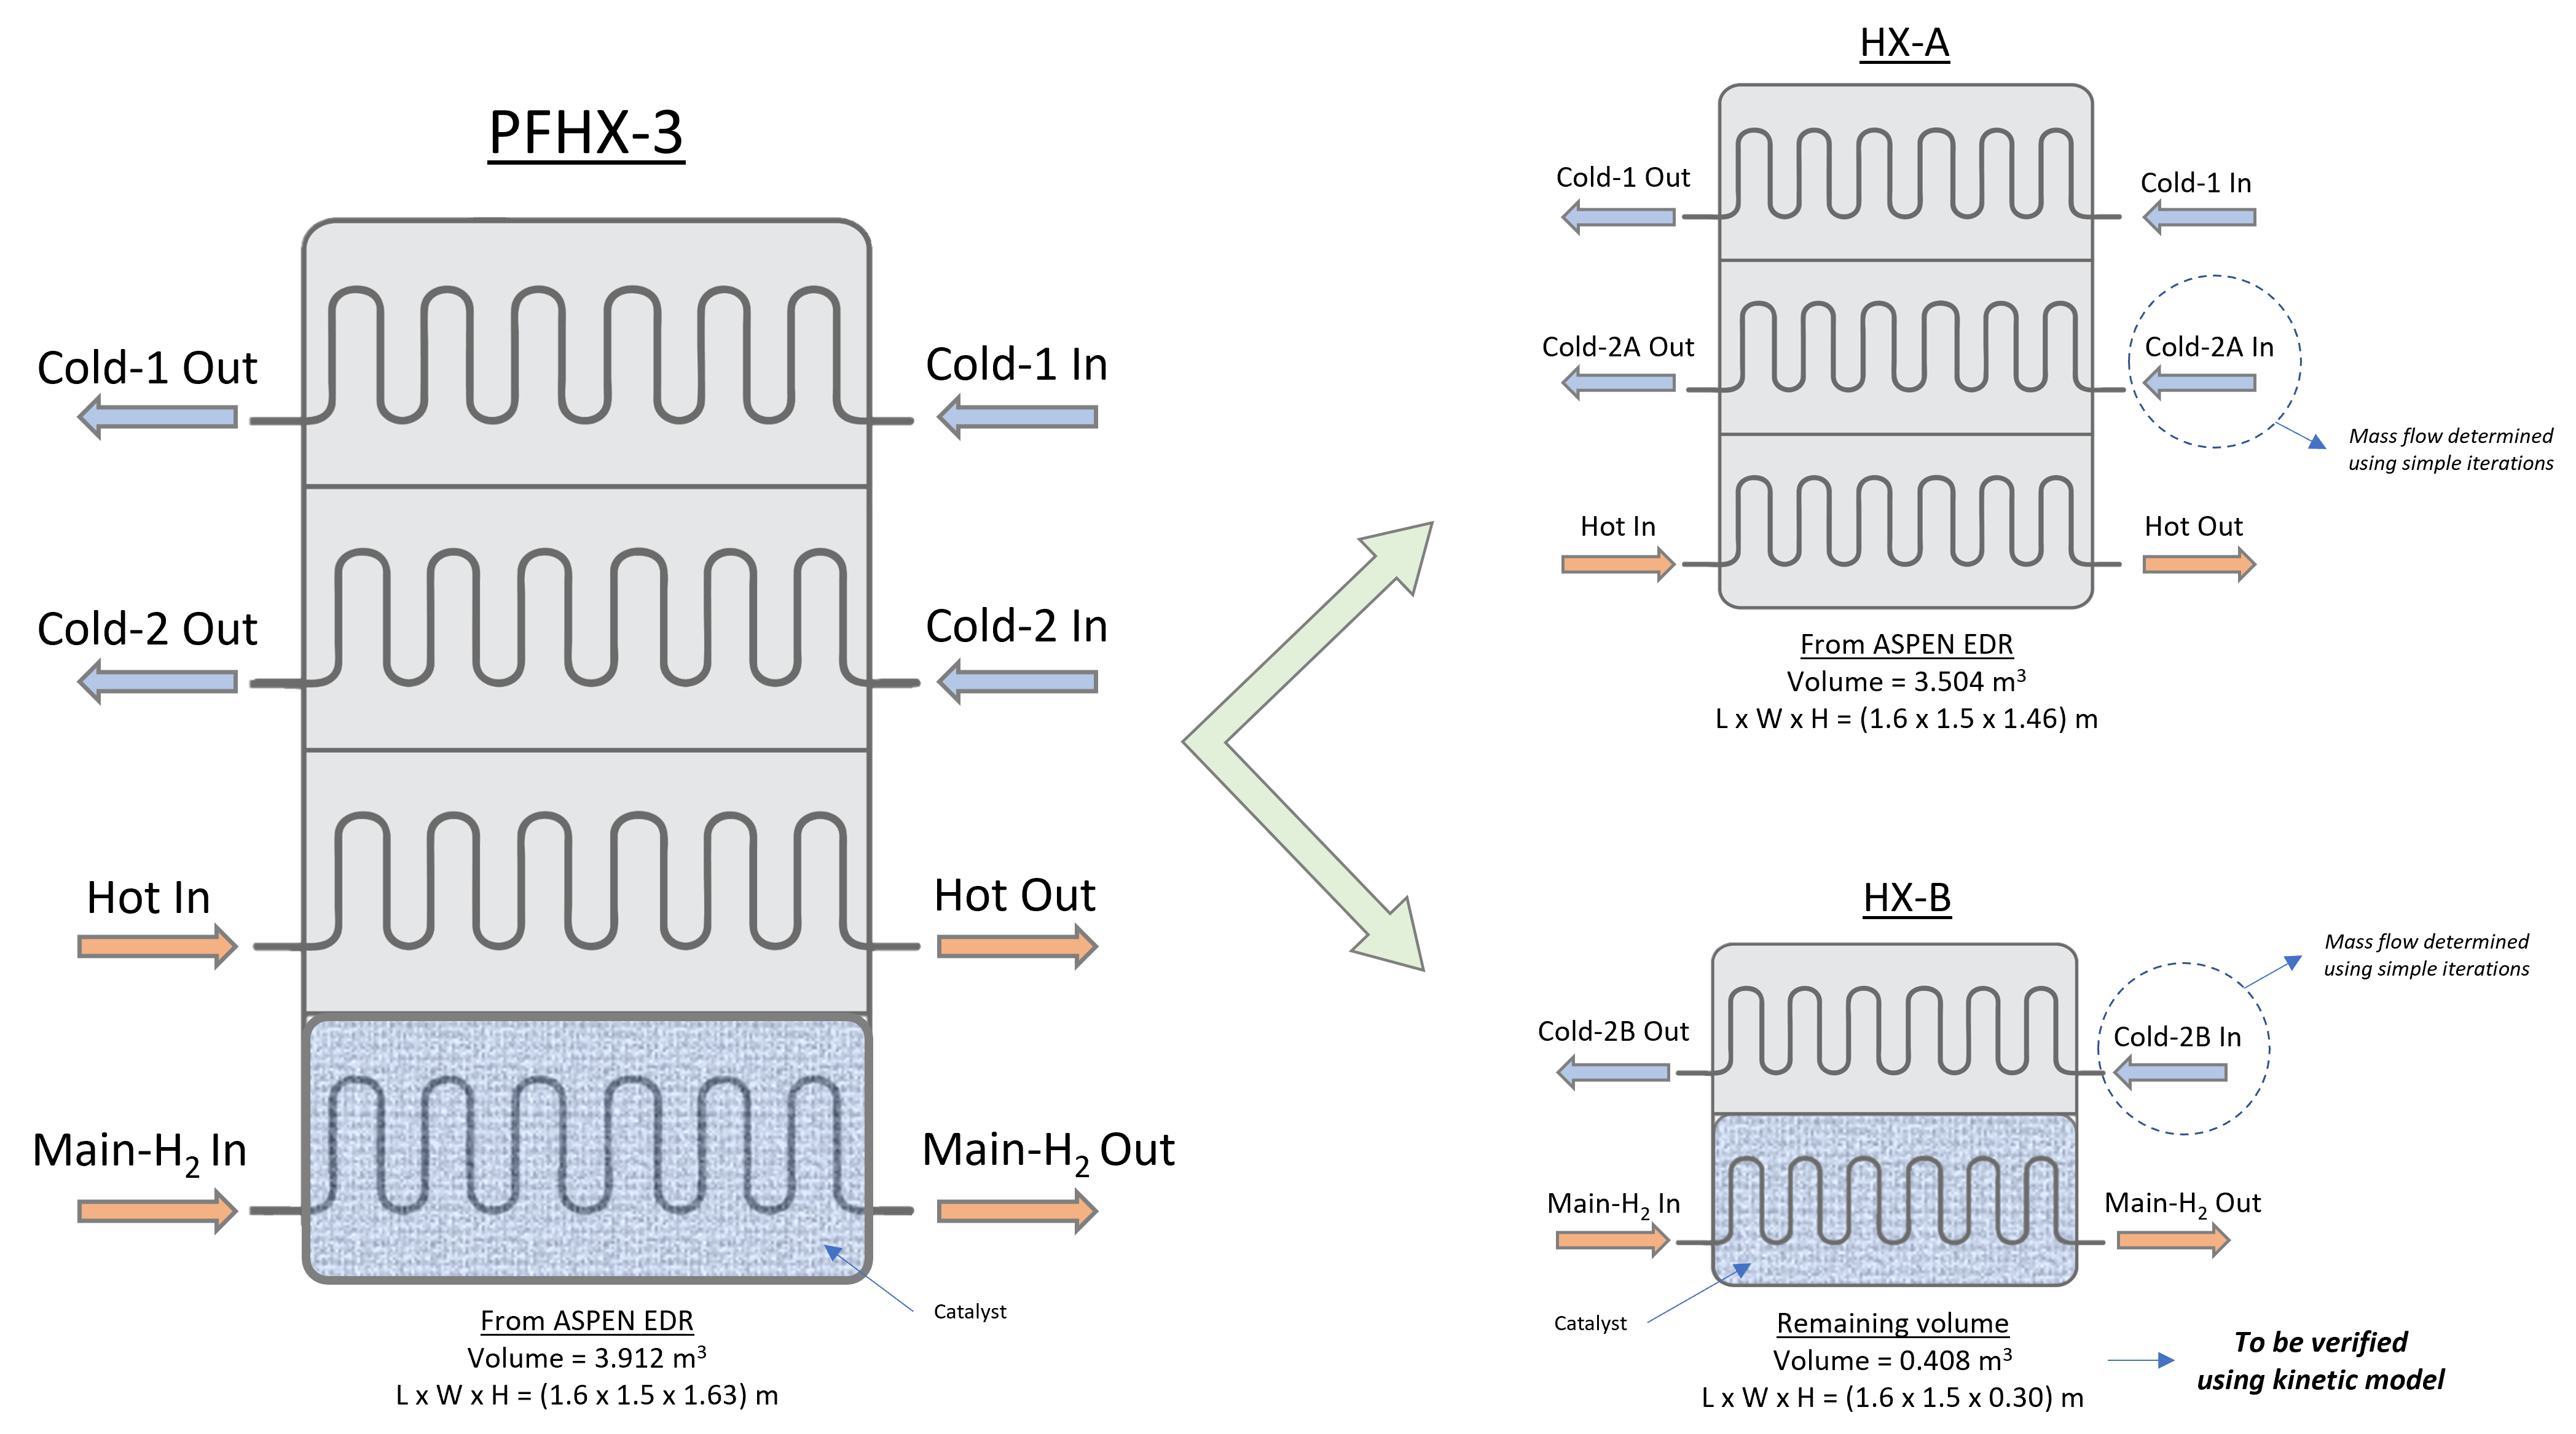

#### In this explanation, the **Plate-Fin Heat Exchanger HX-3** of the hydrogen Claude-cyle liquefier from the paper is taken as an example.  

In [4]:
import sys
sys.path.append('..')
import streamProps # We call streamProps to fetch REFPROP fluid properties
import math

class Format:
    end = '\033[0m'
    underline = '\033[4m'

1. In the first step, we create stream objects for each stream in the original **HX-3** using streamProps. Naming of the streams follows the above schematic.

In [5]:
print(Format.underline + "COLD STREAMS" + Format.end + "(from ASPEN HYSYS)")
cold1_In = streamProps.ThermoState("TP", "REFPROP::HYDROGEN", 111.000, 1.1000*1e5, 2315.5721/3600, "R12")
cold1_In.printState() # This function prints out the enthalpy and entropy of the stream
cold1_Out = streamProps.ThermoState("TP", "REFPROP::HYDROGEN", 118.400, 1.0500*1e5, cold1_In.M, "R13")
cold1_Out.printState()

cold2_In = streamProps.ThermoState("TP", "REFPROP::HYDROGEN", 102.340, 7.5948*1e5, 49190.8021/3600, "R25")
cold2_In.printState()
cold2_Out = streamProps.ThermoState("TP", "REFPROP::HYDROGEN", 111.2185, 7.4948*1e5, cold2_In.M, "R26")
cold2_Out.printState()

print(Format.underline + "HOT STREAMS" + Format.end + "(from ASPEN HYSYS)")
mainH2_In = streamProps.ThermoState("TP", "REFPROP::EQHYDROGEN", 114.000, 19.7780*1e5, 5208.0000/3600, "F03")
mainH2_In.x_para = 0.25 # Adding the para-H2 composition specification to the incoming hydrogen feed-to-product stream
print("F03 p-H2 mole fraction: " + str(round(mainH2_In.x_para,3)))
mainH2_In.printState()
mainH2_Out = streamProps.ThermoState("TP", "REFPROP::EQHYDROGEN", 106.000, 19.7300*1e5, mainH2_In.M, "F04")
mainH2_Out.printState()
# The "REFPROP::EQHYDROGEN" fluid is the pseudo-equilibrium model by Valenti et al. [27], implemented by
# modifying the original REFPROP fluid file of parahydrogen (see paper for more details)

hot_In = streamProps.ThermoState("TP", "REFPROP::HYDROGEN", 119.400, 29.7000*1e5, 51506.3741/3600, "R02")
hot_In.printState()
hot_Out = streamProps.ThermoState("TP", "REFPROP::HYDROGEN", 112.000, 29.6000*1e5, hot_In.M, "R03")
hot_Out.printState()

COLD STREAMS(from ASPEN HYSYS)
Stream R12
M [kg/s]    =  0.6432
P [bar]     =  1.1
T [Kelvin]  =  111.0
H [kJ/kg]   =  1429.742
S [kJ/kg.K] =  40.055


Stream R13
M [kg/s]    =  0.6432
P [bar]     =  1.05
T [Kelvin]  =  118.4
H [kJ/kg]   =  1516.03
S [kJ/kg.K] =  40.999


Stream R25
M [kg/s]    =  13.6641
P [bar]     =  7.595
T [Kelvin]  =  102.34
H [kJ/kg]   =  1321.755
S [kJ/kg.K] =  31.072


Stream R26
M [kg/s]    =  13.6641
P [bar]     =  7.495
T [Kelvin]  =  111.22
H [kJ/kg]   =  1424.875
S [kJ/kg.K] =  32.093


HOT STREAMS(from ASPEN HYSYS)
F03 p-H2 mole fraction: 0.25
Stream F03
M [kg/s]    =  1.4467
P [bar]     =  19.778
T [Kelvin]  =  114.0
H [kJ/kg]   =  1911.929
S [kJ/kg.K] =  36.892


Stream F04
M [kg/s]    =  1.4467
P [bar]     =  19.73
T [Kelvin]  =  106.0
H [kJ/kg]   =  1799.713
S [kJ/kg.K] =  35.881


Stream R02
M [kg/s]    =  14.3073
P [bar]     =  29.7
T [Kelvin]  =  119.4
H [kJ/kg]   =  1501.755
S [kJ/kg.K] =  27.056


Stream R03
M [kg/s]    =  14.3073
P [bar]     = 

2. After we specified the original streams, we now calculate the 'dummy streams' for **HX-A** and **HX-B**. The incoming cold stream with the larger mass flowrate, *R25* in this case, is split into two virtual streams: *R25A* and *R25B*, entering **HX-A** and **HX-B**

In [3]:
# The mass flows of R25A and R25B are then determined iteratively (scipy optimization) using the energy balance equation
# equation for a steady-state counterflow heat exchanger (assuming no heat loss to the surroundings and changes in 
# the kinetic and potential energy):

from scipy.optimize import minimize_scalar

def objective_function(x):
    return abs(cold1_In.M*(cold1_In.H-cold1_Out.H) + x*(cold2_In.H-cold2_Out.H) + hot_In.M*(hot_In.H-hot_Out.H))

res = minimize_scalar(objective_function)
massFlow2A = res.x

cold2A_In = streamProps.ThermoState("TP", "REFPROP::HYDROGEN", cold2_In.T, cold2_In.P, massFlow2A, "R25A")
cold2A_In.printState()
cold2B_In = streamProps.ThermoState("TP", "REFPROP::HYDROGEN", cold2_In.T, cold2_In.P, cold2_In.M-massFlow2A, "R25B")
cold2B_In.printState()

Stream R25A
M [kg/s]    =  12.0909
P [bar]     =  7.595
T [Kelvin]  =  102.34
H [kJ/kg]   =  1321.755
S [kJ/kg.K] =  31.072


Stream R25B
M [kg/s]    =  1.5732
P [bar]     =  7.595
T [Kelvin]  =  102.34
H [kJ/kg]   =  1321.755
S [kJ/kg.K] =  31.072




3. Once flowrates are determined, **HX-A** is sized using Aspen EDR design mode, with predefined width following those obtained for **HX-3** from Step 1. As a result, the volume of **HX-A** is always smaller than that of **HX-3**.

In [4]:
# The initial geometry of HX-3 obtained from ASPEN EDR (ignoring the conversion kinetics of ortho-to-para)
lengthPFHX = 1.5996
widthPFHX = 1.5000
heightPFHX = 1.6309
volumePFHX = lengthPFHX*widthPFHX*heightPFHX

print(Format.underline + "Overall PFHX Geometry" + Format.end)
print("(based on ASPEN EDR)")
print("Length [m]  = ", lengthPFHX)
print("Width  [m]  = ", widthPFHX)
print("Height [m]  = ", heightPFHX)
print("Volume [m3] = ", round(volumePFHX,3))
print("\n")

# The geometry of HX-A obtained from ASPEN EDR based on streams 'Hot', 'Cold 1' and 'Cold 2A'
lengthHXA     = 1.45101
widthHXA      = 1.5000
heightHXA     = 1.4645
volumeHXA     = lengthHXA*widthHXA*heightHXA

print(Format.underline + "HXA Geometry" + Format.end)
print("(based on ASPEN EDR)")
print("Length [m]  = ", lengthHXA)
print("Width  [m]  = ", widthHXA)
print("Height [m]  = ", heightHXA)
print("Volume [m3] = ", round(volumeHXA,3))
print("\n")

Overall PFHX Geometry
(based on ASPEN EDR)
Length [m]  =  1.5996
Width  [m]  =  1.5
Height [m]  =  1.6309
Volume [m3] =  3.913


HXA Geometry
(based on ASPEN EDR)
Length [m]  =  1.45101
Width  [m]  =  1.5
Height [m]  =  1.4645
Volume [m3] =  3.188




4. Based on the geometry of **HX-3** and **HX-A**, we determine the initial geometry of **HX-B**.

In [5]:
# The initial length and width of HX-B follow those of HX-3. While the height is calculated from the difference between 
# the volumes of HX-3 and HX-A, divided by the multiplication of the length and height of HX-3.
volumeHXB     = volumePFHX - volumeHXA
lengthHXB     = lengthPFHX
widthHXB      = widthPFHX
heightHXB     = volumeHXB/(lengthHXB*widthHXB)
print(Format.underline + "HXB Geometry" + Format.end)
print("Length [m]  = ", lengthHXB)
print("Width  [m]  = ", widthHXB)
print("Height [m]  = ", round(heightHXB,3))
print("Volume [m3] = ", round(volumeHXB,3))
print("\n")

HXB Geometry
Length [m]  =  1.5996
Width  [m]  =  1.5
Height [m]  =  0.302
Volume [m3] =  0.726




5. With these specifications, **HX-B** is subjected to simulation using the catalytic PFHX kinetic model of O’Neil et al. [31]. This simulation provides plots depicting the temperature and velocity profile of the streams as well as the para-H2 composition of the main-H2 stream along the length of the heat exchanger:

HX-B Geometry
Length [m]  =  1.5996
Width  [m]  =  1.5
Height [m]  =  0.302
Volume [m3] =  0.726

###### Running Simulation ######
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.79e-06       0.00e+00          50              0       
Solved in 1 iterations, number of nodes 50. 
Maximum relative residual: 1.79e-06 
Maximum boundary residual: 0.00e+00


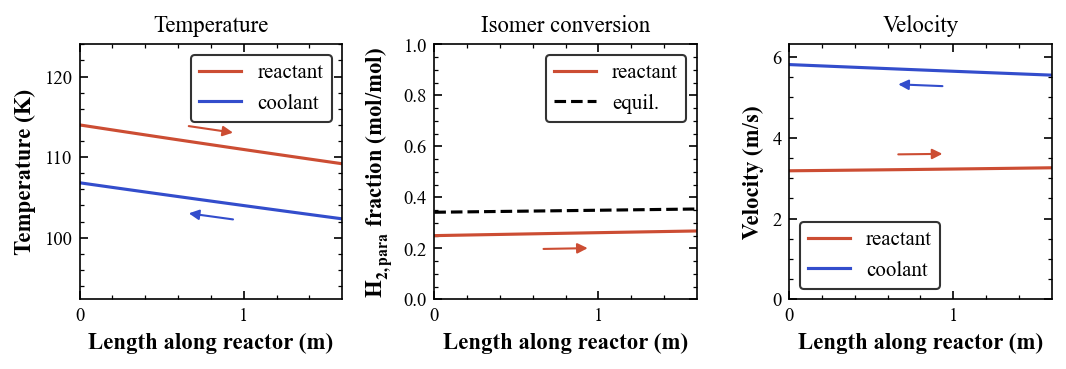

In [6]:
# Test for verifying model

### CONFIGURATION ###
configuration = {
    'reactant': {
        'mass_flow_rate': mainH2_In.M*86.4, # tonne-per-day
        'x_para': mainH2_In.x_para,         # para-hydrogen fraction at inlet
        'temperature': mainH2_In.T,         # inlet temperature (K)
        'pressure': mainH2_In.P/1000        # inlet pressure (kPa)
    },
    'coolant': {
        'fluid': "Hydrogen",                # type of coolant
        'x_para': 0.25,                     # normal hydrogen
        'mass_flow_rate': cold2B_In.M*86.4, # tonne-per-day
        'temperature':  cold2B_In.T,        # temperature of coolant at inlet (K)
        'pressure': cold2B_In.P/1000        # pressure of coolant at inlet (kPa)
    },
    'reactor': {
        'length': lengthHXB,              # m # Initial length of HX-B
        'width': widthHXB,                # m # Initial width of HX-B
        'height': heightHXB,              # m # Initial height of HX-B
        'fin_thickness': 0.2e-3,          # m
        'fin_height': 8.9e-3,             # m
        'fin_pitch': 1.27e-3,             # m
        'seration_length': 3.0e-3,        # m
        'parting_sheet_thickness': 1.5e-3 # m
    },
    'catalyst': {
        'solid_fraction': 0.31,       # volumetric fraction of catlayst particles within reactor
        'diameter': 424.0e-6,         # mean particle diameter
        'density': 4.0                # solid density of catalyst particles (g/cm3)
    },
    'simulation': {
        'nodes': 50,                  # number of nodes across reactor length to setup
        'tolerance': 1.0e-4,          # tolerance of bvp solver
        'delta_t': 1.0                # initial guess of temperature difference between streams
    }
}

# Import packages from O'Neil et al. [31]
import matplotlib
from hydrogen_pfhx import model, outputs

print(Format.underline + "HX-B Geometry" + Format.end)
print("Length [m]  = ", lengthHXB)
print("Width  [m]  = ", widthHXB)
print("Height [m]  = ", round(heightHXB,3))
print("Volume [m3] = ", round(volumeHXB,3))

# Run the model with config
print('\n###### Running Simulation ######')
results = model.model(configuration)

# Plot & display results!
outputs.plot_results(results)
matplotlib.pyplot.draw()
matplotlib.pyplot.savefig('HX-3_init.png')

6. As observed in the previous simulation, the initial sizing of the **HX-3** appears to be insufficient for the conversion process to reach equilibrium. Thus, the initial dimensions of **HX-3** need readjustment, followed by height recalculation and kinetic simulation of **HX-B**, repeating Steps 4 and 5.

7. Adjust **HX-3** dimensions and evaluate **HX-B** simulation results until the desired temperature profile of the streams and the final para-hydrogen composition are achieved in **HX-B**

Final HX-3 Geometry
Length [m]  =  4.0
Width  [m]  =  1.5
Height [m]  =  3.0
Volume [m3] =  18.0


HX-B Geometry
Length [m]  =  4.0
Width  [m]  =  1.5
Height [m]  =  2.469
Volume [m3] =  14.812

###### Running Simulation ######
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          3.93e-06       0.00e+00          50              0       
Solved in 1 iterations, number of nodes 50. 
Maximum relative residual: 3.93e-06 
Maximum boundary residual: 0.00e+00


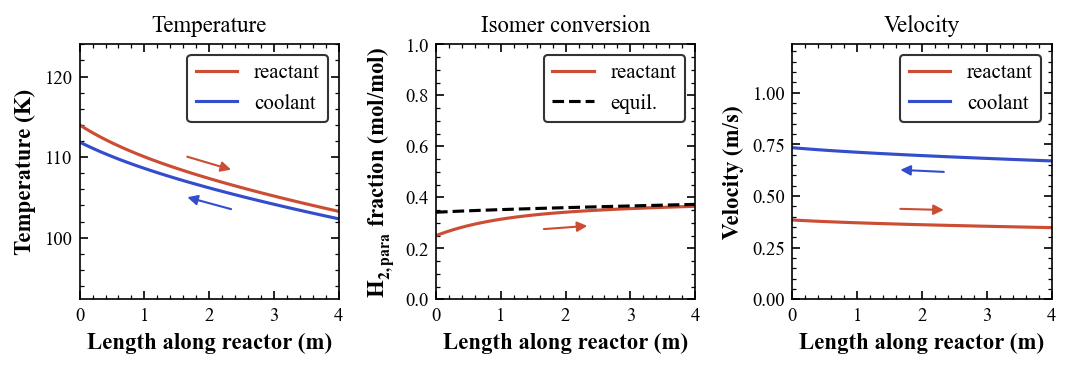

In [7]:
# New HX-3 geometry:
lengthPFHX = 4.0 # m
widthPFHX  = 1.5 # m
heightPFHX = 3.0 # m
volumePFHX = lengthPFHX*widthPFHX*heightPFHX

# Recalculation of HX-B geometry:
volumeHXB     = volumePFHX - volumeHXA
lengthHXB     = lengthPFHX
widthHXB      = widthPFHX
heightHXB     = volumeHXB/(lengthHXB*widthHXB)

# Reevaluation of HX-B simulation

### CONFIGURATION ###
configuration = {
    'reactant': {
        'mass_flow_rate': mainH2_In.M*86.4, # tonne-per-day
        'x_para': mainH2_In.x_para,         # para-hydrogen fraction at inlet
        'temperature': mainH2_In.T,         # inlet temperature (K)
        'pressure': mainH2_In.P/1000        # inlet pressure (kPa)
    },
    'coolant': {
        'fluid': "Hydrogen",          # type of coolant
        'x_para': 0.25,               # normal hydrogen
        'mass_flow_rate': cold2B_In.M*86.4,  # tonne-per-day
        'temperature':  cold2B_In.T,        # temperature of coolant at inlet (K)
        'pressure': cold2B_In.P/1000        # pressure of coolant at inlet (kPa)
    },
    'reactor': {
        'length': lengthHXB,                # m
        'width': widthHXB,                 # m
        'height': heightHXB,                # m
        'fin_thickness': 0.2e-3,      # m
        'fin_height': 8.9e-3,         # m
        'fin_pitch': 1.27e-3,         # m
        'seration_length': 3.0e-3,    # m
        'parting_sheet_thickness': 1.5e-3 # m
    },
    'catalyst': {
        'solid_fraction': 0.31,       # volumetric fraction of catlayst particles within reactor
        'diameter': 424.0e-6,         # mean particle diameter
        'density': 4.0                # solid density of catalyst particles (g/cm3)
    },
    'simulation': {
        'nodes': 50,                  # number of nodes across reactor length to setup
        'tolerance': 1.0e-4,          # tolerance of bvp solver
        'delta_t': 1.0                # initial guess of temperature difference between streams
    }
}

# import packages
import matplotlib
from hydrogen_pfhx import model, outputs

print(Format.underline + "Final HX-3 Geometry" + Format.end)
print("Length [m]  = ", lengthPFHX)
print("Width  [m]  = ", widthPFHX)
print("Height [m]  = ", heightPFHX)
print("Volume [m3] = ", round(volumePFHX,3))
print("\n")

print(Format.underline + "HX-B Geometry" + Format.end)
print("Length [m]  = ", lengthHXB)
print("Width  [m]  = ", widthHXB)
print("Height [m]  = ", round(heightHXB,3))
print("Volume [m3] = ", round(volumeHXB,3))

# run the model with config
print('\n###### Running Simulation ######')
results = model.model(configuration)

# plot & display results!
outputs.plot_results(results)
matplotlib.pyplot.draw()
matplotlib.pyplot.savefig('HX-3_final.png')

8. To print the results of the calculated streams' temperature, pressure, velocity and para-hydrogen composition at the each simulation node of **HX-B**, use the following line:

In [8]:
print(results)

       Z (m)  Reactant pressure (kPa)  Coolant pressure (kPa)  \
0   0.000000              1977.800000              759.340711   
1   0.081633              1977.681276              759.343760   
2   0.163265              1977.563031              759.346795   
3   0.244898              1977.445242              759.349819   
4   0.326531              1977.327888              759.352830   
5   0.408163              1977.210946              759.355831   
6   0.489796              1977.094401              759.358821   
7   0.571429              1976.978234              759.361801   
8   0.653061              1976.862432              759.364770   
9   0.734694              1976.746980              759.367730   
10  0.816327              1976.631865              759.370680   
11  0.897959              1976.517077              759.373621   
12  0.979592              1976.402603              759.376553   
13  1.061224              1976.288435              759.379476   
14  1.142857             